# Semantic Segmentation of Satellite Images 

The task here is to segment the satellite images by training a deep neural network and outputting per-pixel mask of the image.  

## Importing Libraries 

In [1]:
import cv2
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from random import randint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D,ReLU, concatenate, BatchNormalization,MaxPooling2D, Dropout,Conv2DTranspose, UpSampling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import plot_model
from osgeo import gdal




### Important parameters to define the training and testing data

In [2]:
n_channels =3
n_train = 400
n_valid = 100
n_test = 30

## Data Preparation

Images are in .tif format. We start by looking at number of bands in the input image and extract only bands 4,3,2 if we want to train model on RGB images else we extract all bands and convert it into an array

In [3]:
def raster2img(img_data):
    bands_count= img_data.RasterCount
    
    if n_channels==3:
        r = img_data.GetRasterBand(4)
        g = img_data.GetRasterBand(3)
        b = img_data.GetRasterBand(2)
        
        r = r.ReadAsArray()
        g = g.ReadAsArray()
        b = b.ReadAsArray()
        
        img = np.dstack((r,g,b))
        out = np.zeros_like(img).astype(np.float32)
        n = img.shape[2]
        for i in range(n):
            a,b = 0,1
            c = np.percentile(img[:,:,i],2)
            d = np.percentile(img[:,:,i],98)
            t = a+(img[:,:,i]-c)*(b-a)/(d-c)
            t[t<a] = a
            t[t>b] = b
            out[:,:,i] = t
    
    elif n_channels==12:
        img = np.zeros([64,64,bands_count])
        out = np.zeros_like(img).astype(np.float32)
        for i in range(bands_count):
            data = img_data.GetRasterBand(1)
            img[:,:,i] = data.ReadAsArray(0,0,img_data.RasterXSize,img_data.RasterYSize)

            a,b = 0,1
            c = np.percentile(img[:,:,i],2)
            d = np.percentile(img[:,:,i],98)
            t = a+(img[:,:,i]-c)*(b-a)/(d-c)
            t[t<a] = a
            t[t>b] = b

            out[:,:,i] = t
        
    return out

Now we want to split the images for training, validation and testing. We split in ratio of 80:20. A function is defined to split the images and the path has to be specified before hand

In [4]:
def images_split(total_images_path,n_train,n_valid,n_test):
    total_images = []
    count = 0
    if count <530:
        count = count + 1 

        for file in glob.iglob(total_images_path+'**/*.tif',recursive=True):
            
            image = gdal.Open(file, gdal.GA_ReadOnly)
            output_image = raster2img(image)
            total_images.append(output_image)
    
    total_images_count = len(total_images)
    total_images = np.asarray(total_images)
    X_train = []
    X_valid = []
    X_test = []

    for i in range(0,n_train):
        X_train.append(total_images[i])

    for i in range(n_train,n_train+n_valid):
        X_valid.append(total_images[i])

    for i in range(n_train+n_valid,n_train+n_valid+n_test):
        X_test.append(total_images[i])
    
    X_train = np.asarray(X_train)
    X_valid = np.asarray(X_valid)
    X_test = np.asarray(X_test)

    return X_train,X_valid,X_test
    

In [5]:
total_images_path= 'D:/vision_impulse/images/'
X_train, X_valid, X_test = images_split(total_images_path,n_train,n_valid,n_test)

Like Images the labels are also in .tif format. But labels are single banded images. So we extract that solo band and convert to image of 1 channel.

In [6]:
def raster2label(img_data):
    bands_count = img_data.RasterCount
    if bands_count ==1:
        gray = img_data.GetRasterBand(1)

        gray1 = gray.ReadAsArray()

        label = np.asarray(gray1)
        
    return label

In [7]:
def labels_split(total_labels_path,n_train,n_valid,n_test):
    total_labels = []
    count = 0
    if count < 530:
        count = count + 1
        for file in glob.iglob(total_labels_path+'**/*.tif',recursive=True):
            label = gdal.Open(file, gdal.GA_ReadOnly)
            g = label.GetRasterBand(1)
            g = label.ReadAsArray()
            g = g.reshape((64,64,1))
        #print(g)        
        #output_label = raster2label(label)

            total_labels.append(g)
    
    total_label_count = len(total_labels)
    total_labels = np.asarray(total_labels)

    y_train = []
    y_valid = []
    y_test = []

    for i in range(0,n_train):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_train.append(l)

    for i in range(n_train,n_train+n_valid):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_valid.append(l)

    for i in range(n_train+n_valid,n_train+n_valid+n_test):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_test.append(l)
    
    y_train = np.asarray(y_train)
    y_valid = np.asarray(y_valid)
    y_test = np.asarray(y_test)

    return y_train,y_valid,y_test


In [8]:
total_labels_path = 'D:/vision_data_duplicate/vision_impulse/labels/'
y_train, y_valid, y_test = labels_split(total_labels_path,n_train,n_valid,n_test)

Just to make sure if the sizes of both images and labels are equal we use assert and check if they are of same size.

In [9]:
assert X_train.shape[0] == y_train.shape[0]
print(f'X_train and y_train are of same length : {X_train.shape[0]}')

X_train and y_train are of same length : 400


Finally we print the shapes and sizes of the images and labels in all the category splits.

In [10]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(400, 64, 64, 3)
(100, 64, 64, 3)
(30, 64, 64, 3)
(400, 64, 64, 3)
(100, 64, 64, 3)
(30, 64, 64, 3)


It is well-known that matplotlib cannot plot a 12 channel image. So, in case of working with 12 channel image, we visualize predicted image label and actual label. If the image is RGB we visualize input image, input label and predicted image.

In [11]:
def visualize(viz_list):

    if n_channels ==3:
        plt.figure(figsize=(15,15))
        title = ['Input_image', 'Input_mask', 'predicted_mask']
        for i in range(len(viz_list)):
            plt.subplot(1,len(viz_list), i+1)
            plt.title(title[i])
            plt.imshow(viz_list[i])
            plt.axis('off')
        plt.show()
        
    else:
        plt.figure(figsize=(15,15))
        title = ['input_mask','predicted_mask']
        for i in range(len(viz_list)):
            plt.subplot(1,len(viz_list),i+1)
            plt.title(title[i])
            plt.imshow(viz_list[i])
            plt.axis('off')
        plt.show()
    

58


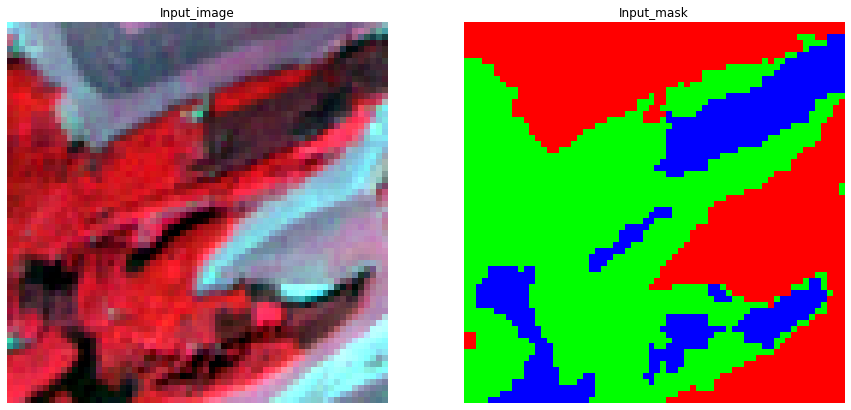

In [12]:
rand_num = randint(0,len(X_train))
print(rand_num)
visualize([X_train[rand_num],y_train[rand_num]])

## Building Models and picking the model

In coming blocks I built multiple models like a vanilla U-Net model, a DeepLabv3 model and a U_net model pre trained and with image net weights along with VGG encoder. 

For u_net with VGG encoder, we extract particular blocks from it and downsample the image followed by upsampling the model.

In [13]:
def upsample(filters, size, strides):
    """Upsample the input"""

    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                      padding="same",
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
   
    result.add(tf.keras.layers.ReLU())
    return result


base_model = VGG19(input_shape=(64,64,n_channels), include_top=False, weights="imagenet")

layers_names = [
    "block2_conv1",    
    "block2_conv2",    
    "block3_conv1",    
    "block3_conv2",    
    "block4_conv1",    
    "block4_conv2",    
    "block5_conv1",    
]

layers = [base_model.get_layer(name).output for name in layers_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False


up_stack = [
    upsample(512, 3, 1),   
    upsample(512, 3, 2),   
    upsample(256, 3, 1),    
    upsample(256, 3, 2),   
    upsample(128, 3, 1),   
    upsample(128, 3, 2),  
]     

def unet_vgg(output_channels=3):
    input_lr = tf.keras.layers.Input(shape= (64,64,n_channels))
    x = input_lr

    initializer = tf.random_normal_initializer(0., 0.02)
    output = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, activation='sigmoid',
        padding="same", kernel_initializer=initializer
    )
    
    concat = tf.keras.layers.Concatenate()

    # Downsampling 
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connection
    for up, skip in zip (up_stack, skips):
        x = up(x)
        if up.layers[0].strides == (2, 2):
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

    x = output(x)
    model = Model(inputs=input_lr,outputs=x)
    return model


The model below is normal vanilla U_Net

In [14]:
def U_Net(n_classes=3,im_size=64,n_channels=n_channels,n_filters=32,k_size=3,upconv=True):
    dropout_rate = 0.2
    n_filters = n_filters #32 64x64
    input_lr = Input((im_size,im_size,n_channels))
    conv1 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(input_lr)
    conv1 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv1)
    p1 = MaxPooling2D(pool_size=(2,2))(conv1)
    p1 = Dropout(dropout_rate)(p1)
    p1 = BatchNormalization()(p1)
    
    n_filters *= 2 #64 32x32
    conv2 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p1)
    conv2 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv2)
    p2 = MaxPooling2D(pool_size=(2,2))(conv2)
    p2 = Dropout(dropout_rate)(p2)
    p2 = BatchNormalization()(p2)
    
    n_filters *= 2 #128 16x16
    conv3 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p2)
    conv3 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv3)
    p3 = MaxPooling2D(pool_size=(2,2))(conv3)
    p3 = Dropout(dropout_rate)(p3)
    p3 = BatchNormalization()(p3)
    
    n_filters *= 2 #256 8x8
    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p3)
    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv4)
    conv4 = Dropout(dropout_rate)(conv4)
    conv4 = BatchNormalization()(conv4)

    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv4)
    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv4)
    p4 = MaxPooling2D(pool_size=(2,2))(conv4)
    p4 = Dropout(dropout_rate)(p4)
    p4 = BatchNormalization()(p4)
    
    n_filters *= 2 #512 4x4
    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p4)
    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv5)
    conv5 = Dropout(dropout_rate)(conv5)
    conv5 = BatchNormalization()(conv5)

    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv5)
    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv5)
    p5 = MaxPooling2D(pool_size=(2,2))(conv5)
    p5 = Dropout(dropout_rate)(p5)
    p5 = BatchNormalization()(p5)   
    
    n_filters *= 2 #1024 2x2
    conv6 = Conv2D(filters = n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p5)
    conv6 = BatchNormalization()(conv6)
    
    #upsampling block
    
    n_filters //= 2 #512 4x4
    if upconv:
        up5 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv6)
        up5 = concatenate([up5,conv5])
    else:
        up5 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv6)
        up5 = concatenate([up5,conv5])

    up5 = BatchNormalization()(up5)
    conv7 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up5)
    conv7 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv7)
    conv7 = Dropout(dropout_rate)(conv7)
    
    n_filters //= 2 #256 8x8 
    if upconv:
        up4 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv7)
        up4 = concatenate([up4,conv4])
    else:
        up4 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv7)
        up4 = concatenate([up4,conv4])

    up4 = BatchNormalization()(up4)
    conv8 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up4)
    conv8 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv8)
    conv8 = Dropout(dropout_rate)(conv8)
    
    n_filters //= 2  #128 16x16
    if upconv:
        up3 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv8)
        up3 = concatenate([up3,conv3])
    else:
        up3 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv8)
        up3 = concatenate([up3,conv3])

    up3 = BatchNormalization()(up3)
    conv9 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up3)
    conv9 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv9)
    conv9 = Dropout(dropout_rate)(conv9)
    
    n_filters //= 2  #64 32x32
    if upconv:
        up2 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv9)
        up2 = concatenate([up2,conv2])
    else:
        up2 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv9)
        up2 = concatenate([up2,conv2])

    up2 = BatchNormalization()(up2)
    conv10 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up2)
    conv10 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv10)
    conv10 = Dropout(dropout_rate)(conv10)
    
    n_filters //= 2  #32 64x64
    if upconv:
        up1 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv10)
        up1 = concatenate([up1,conv1])
    else:
        up1 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv9)
        up1 = concatenate([up1,conv1])

    up1 = BatchNormalization()(up1)
    conv11 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up1)
    conv11 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv11)
    conv11 = Dropout(dropout_rate)(conv11)   
    
    output = Conv2D(filters=n_classes,kernel_size=(1,1),padding='same',kernel_initializer='he_normal',activation='softmax')(conv11)
    
    model = Model(inputs = input_lr, outputs = output)
    
    return model

In next steps we train all three models that are constructed above and compare results across each model. To do so, initially we start with unet_vgg with pre-trained 'imagenet' weights.

In [15]:
unet_vgg_model = unet_vgg()
unet_model = U_Net()


In [16]:
unet_vgg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 32, 32, 128) 12944960    input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4, 4, 512)    2361344     model[1][6]                      
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 8, 8, 512)    2361344     sequential[0][0]                 
____________________________________________________________________________________________

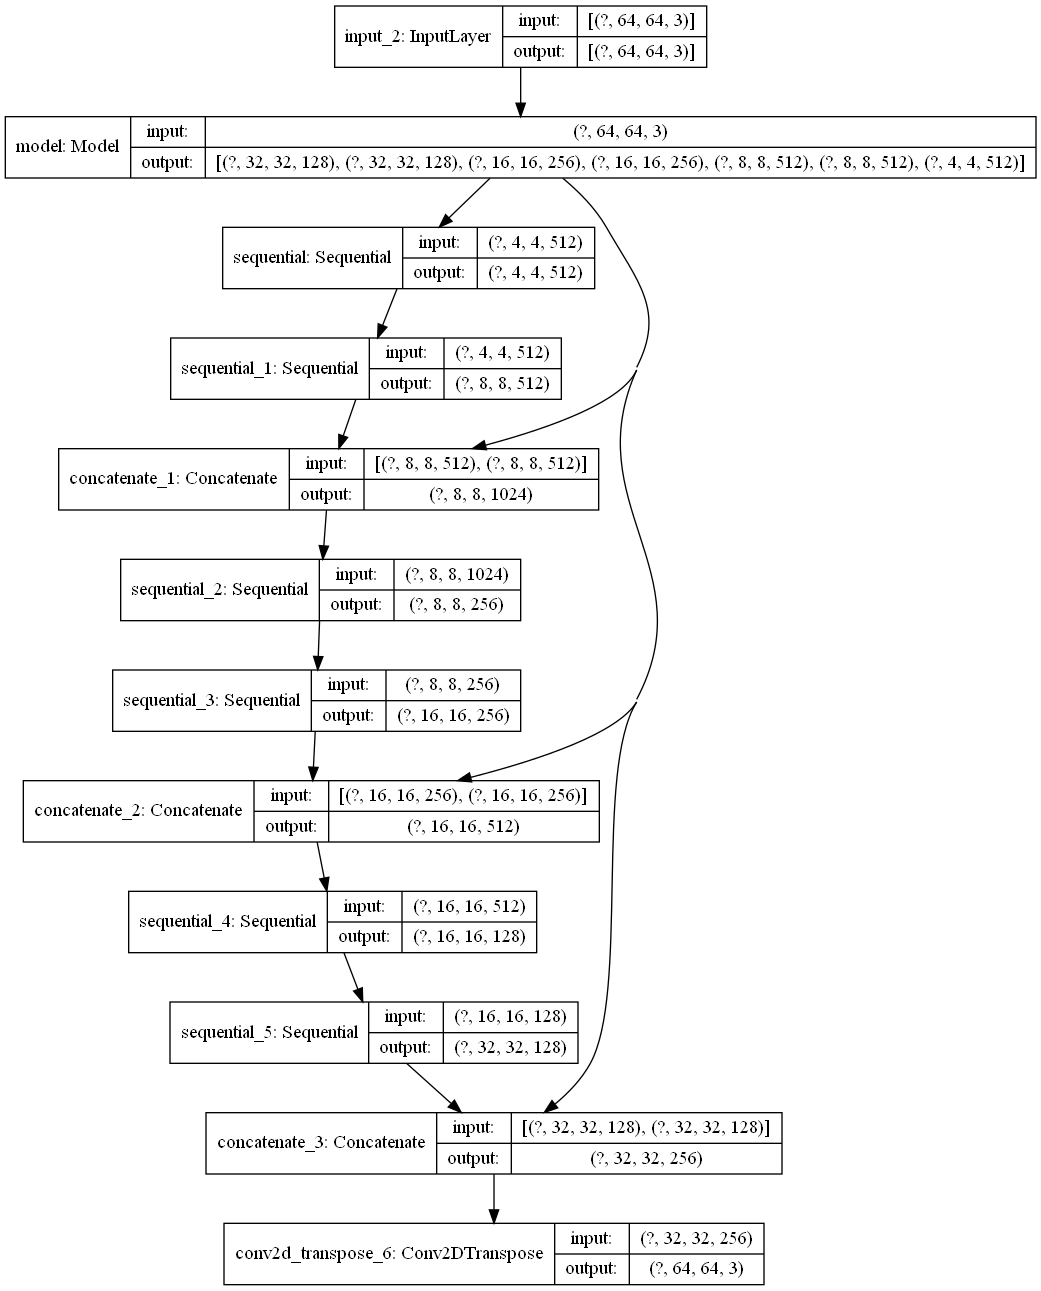

In [17]:
plot_model(unet_vgg_model,to_file='D:/vision_impulse/model_unet_vgg'+'.png',show_shapes=True,show_layer_names=True)

We got the model and we print the statistics on number of total parameters along with count of trainable and non-trainable parameters.

Now model needs to be compiled 

In [18]:
unet_vgg_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Create callbacks namely early-stopping and modelcheckpoint

In [19]:
unet_vgg_weights_path = 'D:/vision_impulse/weights/'
if not os.path.exists(unet_vgg_weights_path):
    os.makedirs(unet_vgg_weights_path)
    
file_path = os.path.join(unet_vgg_weights_path+'model_unet_vgg')
print(file_path)


D:/vision_impulse/weights/model_unet_vgg


In [20]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

es = EarlyStopping(patience=100,monitor='val_loss',mode ='auto',restore_best_weights=True)
mc = ModelCheckpoint(filepath = file_path,monitor='val_loss',save_best_only=True)


### Training Metrics


In [21]:
batch_size= 8
steps_per_epoch = int(len(X_train)//batch_size)
epochs = 200

Start of Training Process

In [22]:
unet_vgg_history = unet_vgg_model.fit(X_train,y_train,steps_per_epoch = steps_per_epoch,validation_data=(X_valid,y_valid),epochs = epochs,callbacks = [es,mc])

Epoch 1/200
50/50 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.6829WARNING:tensorflow:From C:\Users\Dheeraj Reddy P\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:/vision_impulse/weights/model_unet_vgg\assets
50/50 [==============================] - 16s 311ms/step - loss: 0.6550 - accuracy: 0.6829 - val_loss: 0.6119 - val_accuracy: 0.7974
Epoch 2/200
50/50 [==============================] - 10s 194ms/step - loss: 0.4145 - accuracy: 0.8350 - val_loss: 0.5652 - val_accuracy: 0.7960
Epoch 3/200
50/50 [==============================] - 4s 87ms/step - loss: 0.3291 - accuracy: 0.8686 - val_loss: 0.6873 - val_accuracy: 0.7988
Epoch 4/200
50/50 

50/50 [==============================] - 4s 88ms/step - loss: 0.0825 - accuracy: 0.9669 - val_loss: 0.3686 - val_accuracy: 0.8926
Epoch 49/200
50/50 [==============================] - 4s 88ms/step - loss: 0.0775 - accuracy: 0.9687 - val_loss: 0.3515 - val_accuracy: 0.8914
Epoch 50/200
50/50 [==============================] - 4s 88ms/step - loss: 0.0759 - accuracy: 0.9695 - val_loss: 0.3512 - val_accuracy: 0.8943
Epoch 51/200
50/50 [==============================] - 4s 88ms/step - loss: 0.0743 - accuracy: 0.9700 - val_loss: 0.3328 - val_accuracy: 0.8964
Epoch 52/200
50/50 [==============================] - 4s 88ms/step - loss: 0.0765 - accuracy: 0.9694 - val_loss: 0.3698 - val_accuracy: 0.8916
Epoch 53/200
50/50 [==============================] - 4s 88ms/step - loss: 0.0725 - accuracy: 0.9707 - val_loss: 0.3791 - val_accuracy: 0.8902
Epoch 54/200
50/50 [==============================] - 4s 88ms/step - loss: 0.0687 - accuracy: 0.9722 - val_loss: 0.3777 - val_accuracy: 0.8906
Epoch 55/200

50/50 [==============================] - 4s 88ms/step - loss: 0.0270 - accuracy: 0.9900 - val_loss: 0.6839 - val_accuracy: 0.8676
Epoch 106/200
50/50 [==============================] - 4s 88ms/step - loss: 0.0654 - accuracy: 0.9755 - val_loss: 0.5763 - val_accuracy: 0.8812
Epoch 107/200
50/50 [==============================] - 4s 88ms/step - loss: 0.0506 - accuracy: 0.9801 - val_loss: 0.5753 - val_accuracy: 0.8761
Epoch 108/200
50/50 [==============================] - 4s 89ms/step - loss: 0.0297 - accuracy: 0.9887 - val_loss: 0.5539 - val_accuracy: 0.8776


Save the trained model weights 

In [23]:
unet_vgg_model.save('D:/vision_impulse/weights/mymodel.h5')

In [25]:
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

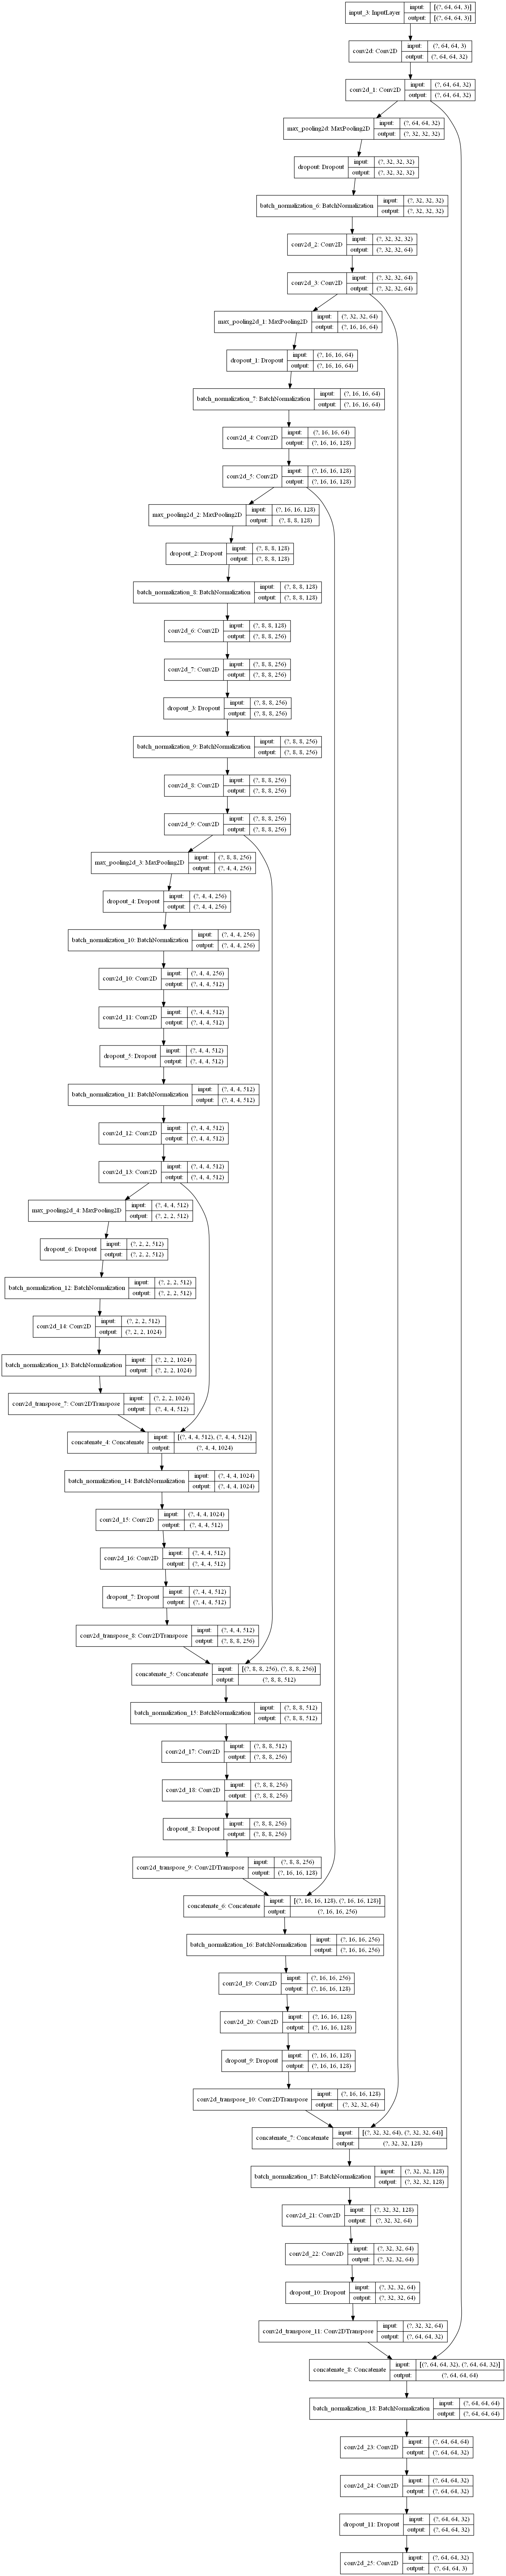

In [26]:
plot_model(unet_model,to_file='D:/vision_impulse/model_u_net'+'.png',show_shapes=True,show_layer_names=True)

In [27]:
unet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
unet_weights_path = 'D:/vision_impulse/weights/'
if not os.path.exists(unet_weights_path):
    os.makedirs(unet_weights_path)
    
file_path = os.path.join(unet_weights_path+'model_unet')
print(file_path)


D:/vision_impulse/weights/model_unet


In [29]:
unet_history = unet_model.fit(X_train,y_train,steps_per_epoch = steps_per_epoch,validation_data=(X_valid,y_valid),epochs = epochs,callbacks = [es,mc])

Epoch 1/200
50/50 [==============================] - 18s 369ms/step - loss: 0.6308 - accuracy: 0.7448 - val_loss: 2.3563 - val_accuracy: 0.6840
Epoch 2/200
50/50 [==============================] - 11s 223ms/step - loss: 0.4990 - accuracy: 0.8050 - val_loss: 7.0051 - val_accuracy: 0.5650
Epoch 3/200
50/50 [==============================] - 11s 226ms/step - loss: 0.4387 - accuracy: 0.8311 - val_loss: 1.4472 - val_accuracy: 0.7039
Epoch 4/200
50/50 [==============================] - 11s 226ms/step - loss: 0.4103 - accuracy: 0.8382 - val_loss: 0.7304 - val_accuracy: 0.8310
Epoch 5/200
50/50 [==============================] - 11s 225ms/step - loss: 0.3963 - accuracy: 0.8465 - val_loss: 0.3419 - val_accuracy: 0.8745
Epoch 6/200
50/50 [==============================] - 11s 223ms/step - loss: 0.3704 - accuracy: 0.8569 - val_loss: 0.9996 - val_accuracy: 0.8152
Epoch 7/200
50/50 [==============================] - 11s 223ms/step - loss: 0.3399 - accuracy: 0.8682 - val_loss: 0.3640 - val_accuracy:

Epoch 52/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1972 - accuracy: 0.9242 - val_loss: 0.2912 - val_accuracy: 0.8956
Epoch 53/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1843 - accuracy: 0.9276 - val_loss: 0.2765 - val_accuracy: 0.9006
Epoch 54/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1831 - accuracy: 0.9278 - val_loss: 0.2489 - val_accuracy: 0.9033
Epoch 55/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1924 - accuracy: 0.9253 - val_loss: 0.2328 - val_accuracy: 0.9076
Epoch 56/200
50/50 [==============================] - 22s 443ms/step - loss: 0.1867 - accuracy: 0.9273 - val_loss: 0.1995 - val_accuracy: 0.9217
Epoch 57/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1799 - accuracy: 0.9295 - val_loss: 0.2067 - val_accuracy: 0.9194
Epoch 58/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1702 - accuracy: 0.9331 - val_loss: 0.2085 - val_ac

50/50 [==============================] - 11s 223ms/step - loss: 0.1373 - accuracy: 0.9446 - val_loss: 0.2221 - val_accuracy: 0.9193
Epoch 107/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1277 - accuracy: 0.9486 - val_loss: 0.2781 - val_accuracy: 0.9093
Epoch 108/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1369 - accuracy: 0.9457 - val_loss: 0.2536 - val_accuracy: 0.9061
Epoch 109/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1561 - accuracy: 0.9376 - val_loss: 0.2755 - val_accuracy: 0.9009
Epoch 110/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1276 - accuracy: 0.9488 - val_loss: 0.2185 - val_accuracy: 0.9176
Epoch 111/200
50/50 [==============================] - 11s 223ms/step - loss: 0.1210 - accuracy: 0.9513 - val_loss: 0.2254 - val_accuracy: 0.9217
Epoch 112/200
50/50 [==============================] - 11s 224ms/step - loss: 0.1176 - accuracy: 0.9526 - val_loss: 0.2635 - val_accuracy:

The final step make predictions and visualize

In [30]:
y_pred_unet_vgg =unet_vgg_model.predict(X_test)

In [31]:
y_pred_unet = unet_model.predict(X_test)

In [36]:

def compare_predictions(pred_list):
    plt.figure(figsize=(15,15))
    title = ['input Image', 'Input Mask','Predicted Unet_vgg','Predicted Unet']
    for i in range(len(pred_list)):
        plt.subplot(1,len(pred_list), i+1)
        plt.title(title[i])
        plt.imshow(pred_list[i])
        plt.axis('off')
    plt.show()

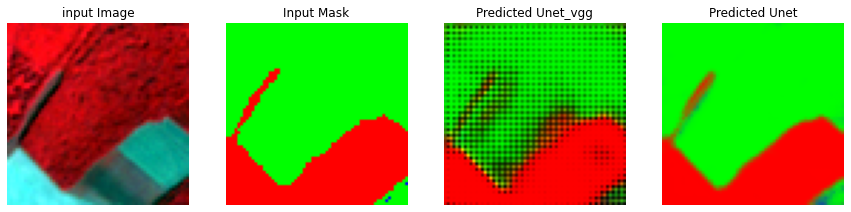

In [39]:
compare_predictions([X_test[0],y_test[0],y_pred_unet_vgg[0],y_pred_unet[0]])

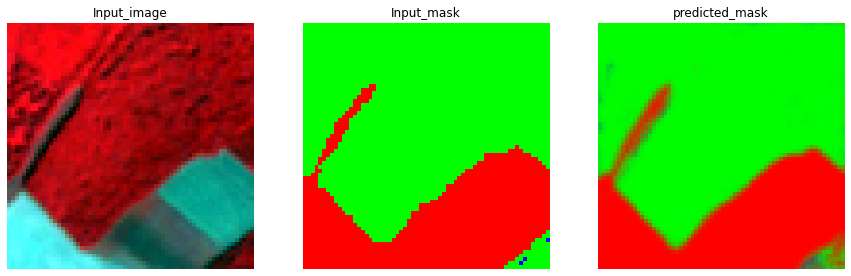

In [29]:
visualize([X_test[0],y_test[0],y_pred[0]])

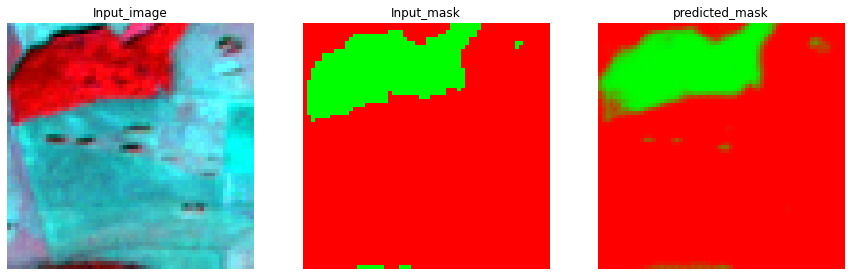

In [30]:
visualize([X_test[12],y_test[12],y_pred[12]])